# Regression

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** At this point, you have the building blocks for developing many commonly-used ML models. Using these building blocks, we will develop a commonly used ML model---regression. A regression model is a *predictive* model (i.e. a conditional distribution), in which the variable we're interested in predicting is *continuous*. 

**Challenge:** Recall that in a conditional distribution, the parameters of the distribution depend on what we're conditioning. For example, when predicting the probability of intorixaction, $I$, given the day of the week, $D$, we can use a model like,
\begin{align}
p_{I | D}(i | d) = \mathrm{Ber}(\rho(d)) = \underbrace{\rho(d)^{i} \cdot \left(1 - \rho(d) \right)^{1 - i}}_{\text{Bernoulli PMF (see Wikipedia)}},
\end{align}
where the parameter, $\rho(d)$, is a function of the condition (i.e. the day $d$):
\begin{align} \rho(d) &= \begin{cases}
0.1 & \text{if $d$ is weekday} \\
0.4 & \text{if $d$ is weekend}
\end{cases} 
\end{align}
As in this model, in all models we've considered so far, the parameters depend on the condition using if-else expressions (e.g. if $d$ is a weekday, then $\rho = 0.1$, else $\rho = 0.4$). Unfortunately, as models become more complex, this approach for specifying a model becomes unwieldy. For example, if instead of conditioning on something simple, like the day, we instead conditioned on something complicated, like medical image---$1000 \times 1000$ pixels in size---how would we write the appropriate if-else expression? Out of a total of 1-million pixels in the image, which ones are important to even include in the if-else expression? The classes of predictive models we will introduce now---regression and (later) classification---precisely allow us to circumvent this issue. How? By making the parameter a more interesting function of the condition. Continuing with the above example, we can define, $\rho(d)$ as a linear function of $d$:
\begin{align}
\rho(d) &= \mathrm{intercept} + \mathrm{slope} \cdot d.
\end{align}
We can similarly make $\rho(d)$ a quadratic, or sinusoidal, or polynomial function of $d$---there are endless possibilities. Of course, in this example, $d$ can be one of two values, so making $\rho(d)$ some function of $d$ is not helpful---but when $d$ is more complicated, like an image, this trick will be incredibly helpful. We will start with simple, linear functions, and build up to more complex functions (using neural networks).

**Outline:**
* Introduce predictive models generally
* Instantiate a regression model as a specific type of predictive model
* Implement the regression in `NumPyro`
* Understand how to quantify model performance

**Data:** Before diving in, let's familiarize ourself with the data set we'll be working with. This data set comes from a special, interdisciplinary effort at the IHH, spanning two major centers. The first is one you're already familiar with: the Center for Telekinesis Research (CTR), dedicated to the study of telekinesis (the ability of moving physical objects with your mind). The second is the Center for Glow and Positive Life Flow (CGLF). As you know, one of the great mysteries of the galaxy is why intergalactic being glow, and what it can tell us about other aspects of their life. As part of this effort, IHH researchers want to understand how glow affects telekinetic ability. They have recruited you to help with the data analysis. 

They sent us a data set consisting of two variables:
* A measure of glow (real number), in which higher values indicate higher brightness
* A measure of telekinetic ability (also real number), in which higher values indicate higher ability (able to move heavier objects to greater heights, etc.)

In [13]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Glow,Telekinetic-Ability
Patient ID,,
90,0.604085,0.079067
254,0.613645,0.029835
283,0.829212,0.240791
445,0.981120,0.361027
461,0.688329,0.072750
15,0.796853,0.066299
316,0.839546,0.444510
489,0.929422,0.368031
159,0.893813,0.522464


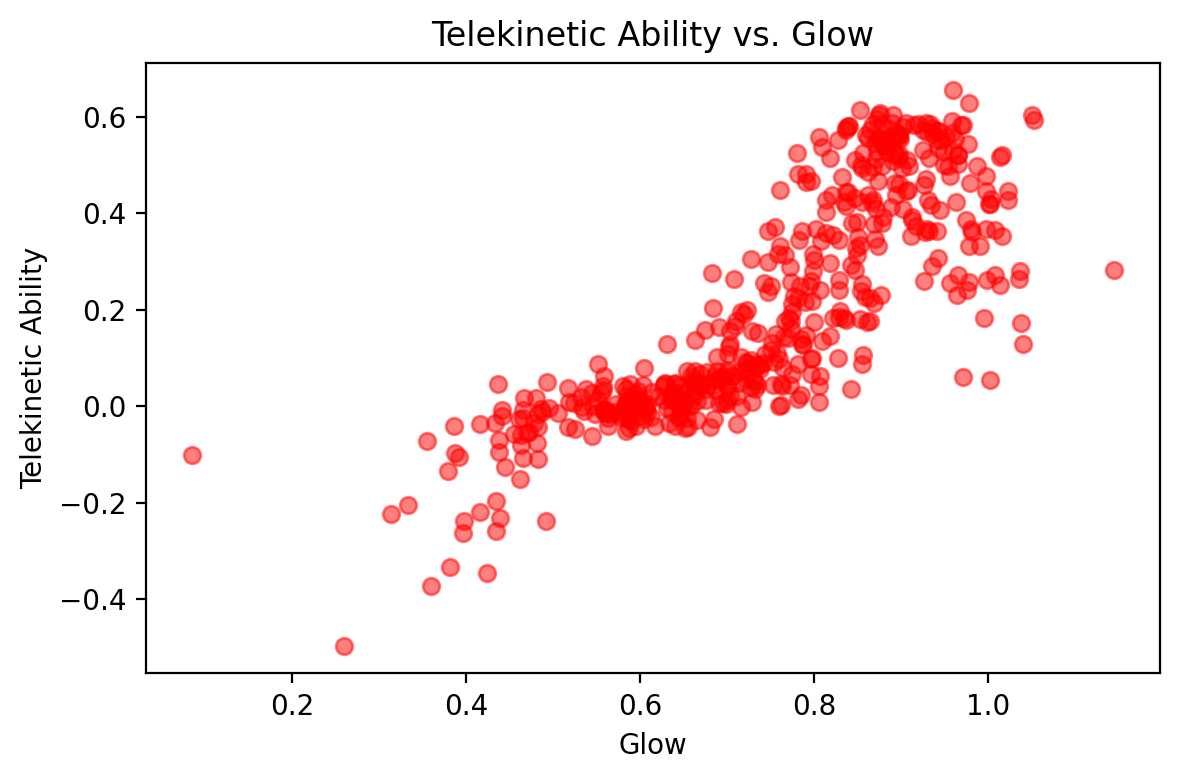

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.scatter(data['Glow'], data['Telekinetic-Ability'], color='red', alpha=0.5)
plt.xlabel('Glow')
plt.ylabel('Telekinetic Ability')
plt.title('Telekinetic Ability vs. Glow')

plt.tight_layout()
plt.show()

## Predictive Models

To understand the effects of glow on telekinetic ability, we will try to see if there is a relationship between them---if glow changes, does telekinetic ability change as well? To do this, we will fit a predictive model (and more specifically, a regression model) to the data. We will then interpret it and see what we learn. Of course, we have to be cautious about our interpretation of the results: just because telekinetic ability may change as a function of glow *does not* mean that it *causes* the change---more on that later.

**Approach.** Since regression models are a specific type of predictive model, let's first describe what a predictive model is using the toolkit we've developed so far. Specifically, we'll describe a predictive model using the directed graphical model and its corresponding generative process. Then, we will write down its joint data distribution and MLE objective.

**Directed Graphical Model.** We have data set of observations of two RVs: "inputs" $X$, representing glow, and "outputs" $Y$, representing telekinetic ability. Our goal is to learn to predict $Y$ from $X$ (i.e. learn a conditional distribution $p_{Y | X}$). Our graphical model should therefore include the following:
* It should have a node for $X$ and a node for $Y$, representing our two random variables.
* It should have an arrow pointing from $X$ into $Y$ to represent $Y$'s dependence on $X$.
* Since we have many i.i.d observations of $(X, Y)$-pairs, we'll need $X$ and $Y$ in a plate.
* Finally, the we'll probably want the relationship between $X$ and $Y$ to be controlled by some parameter, $\theta$, that can be learned from the data.

A predictive model has the following graphical representation:
<div class="canva-centered-embedding">
  <div class="canva-iframe-container">
    <iframe loading="lazy" class="canva-iframe"
      src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGJv58NH1k&#x2F;-MhOv0aEL8dP0kRgjrIN6Q&#x2F;view?embed">
    </iframe>
  </div>
</div>

**Generative Process.** Our graphical model can be directly translated into the following generative process: for $n = 1, \dots, N$,
\begin{align}
x_n &\sim p_X(x_n) \\
y_n | x_n &\sim p_{Y | X}(\cdot | x_n; \theta) 
\end{align}
Notice that we've chosen our marginal over the inputs, $p_X(x_n)$, to *not depend* on any parameters. This is because we *just* care about learning how to predict $Y$ from $X$. That is, we assume our use-case will be that we are *given* specific $x$'s for which we want to make predictions---we therefore don't need to sample them from $p_X(\cdot)$ (or learn $p_X(\cdot)$). As you will see in the derivation of our objective function, $p_X(x_n)$ will not impact our MLE in any way. 

**Joint Data Log-Likelihood.** For the above model, we have the following joint data log-likelihood:
\begin{align}
\log p(\mathcal{D}; \theta) &= \log \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \quad (\text{i.i.d observations}) \\
&= \sum\limits_{n=1}^N \log p(\mathcal{D}_n; \theta) \quad (\text{since } \log(a \cdot b) = \log a + \log b) \\
&= \sum\limits_{n=1}^N \log p_{X, Y}(x_n, y_n; \theta) \quad (\text{since } \mathcal{D}_n = (x_n, y_n)) \\
&= \sum\limits_{n=1}^N \log \left( p_{Y | X}(y_n | x_n; \theta) \cdot p_X(x_n) \right) \quad (\text{using our factorization of the joint}) \\
&= \sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) + \log p_X(x_n) \quad (\text{since } \log(a \cdot b) = \log a + \log b) 
\end{align}

**MLE Objective.** Our goal is to maximize the probability of the joint data log-likelihood with respect to parameters $\theta$:
\begin{align}
\mathrm{argmax}_\theta \log p(\mathcal{D}; \theta) &= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) + \log p_X(x_n) \quad (\text{substituting in our joint data log-likelihood}) \\
&= \mathrm{argmin}_\theta -\sum\limits_{n=1}^N \left( \log p_{Y | X}(y_n | x_n; \theta) + \log p_X(x_n) \right) \quad (\text{taking an argmax is like taking an argmin of the negative}) \\
&= \mathrm{argmin}_\theta -\sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) - \underbrace{\sum\limits_{n=1}^N \log p_X(x_n)}_{\text{does not depend on } \theta} \quad (\text{we split out the sum into two parts}) \\
&= \mathrm{argmin}_\theta -\sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) \quad (\text{term that doesn't depend on $\theta$ doesn't affect argmin}) 
\end{align}
This gives us the following objective (or loss function):
\begin{align}
\mathcal{L}(\theta) = -\sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta)
\end{align}
Now that we have our objective, the only thing missing now is a specific choice of $p_{Y | X}(y_n | x_n; \theta)$; given a specific value of glow, $x_n$, what's the distribution of telekinetic ability, $y_n$? We will next select $p_{Y | X}(y_n | x_n; \theta)$ to give us a regression model. Later, we will do the same for other models (e.g. classification). 

## The Regression Model

**The Model.** Looking at our objective function, $\mathcal{L}(\theta)$, the only thing we need to define is $p_{Y | X}(y_n | x_n; \theta)$. Let's introduce a picture to help our intuition for what this distribution should be. Looking at the plot above of telekinetic ability vs. glow, we see that $p_{Y | X}(y_n | x_n; \theta)$, should have two parts: 
1. It needs some way of accounting for the general "trend". As glow increases, telekinetic ability also increases until the very end, when it drops off.
2. Around this trend, there is some "noise"---no point exactly fits the trend.

To capture both components, we define our model as follows on two made-up data sets:
\begin{align}
p_{Y | X}(\cdot | x_n; \underbrace{W, \sigma}_{\theta}) = \mathcal{N}( \underbrace{\mu(x_n; W)}_{\text{trend}}, \underbrace{\sigma^2}_{\text{noise}} ),
\end{align}
where $\theta = \{ W, \sigma \}$, and where $\mu(\cdot; W)$ is a function parameterized by $W$ (which controls its shape). Putting this all together, our generative process says:
1. We're given an input, $x_n$, from our data.
2. We feed it through our function $\mu(\cdot; W)$ to predict what $y_n$ will be, on average. This captures the "trend."
3. Finally, we add some Gaussian noise to the result. This Gaussian noise represents the error in our measurement. For example, our devices that measure height, blood pressure, etc. at the IHH are correct on average, but are always off by some small amount of random noise. How much noise is determining by the variance of the Gaussian, $\sigma^2$.

Let's visualize what this looks like:

```{figure} _static/figs/example_regression.png
---
name: fig-regression-example
align: center
---
Examples of regression with linear $\mu(\cdot; W)$ (left) and polynomial $\mu(\cdot; W)$ (right).
```

Here, the blue line, representing $\mu(\cdot; W)$ captures the "trend" of the data. The data (in red) surrounds the trend; it lies around it due to the observation error (or noise). In the "linear" regression plot, $\mu(x_n; W)$ is a line, where $W = \{ a, b \}$ is the slope and intercept of a line:
\begin{align}
a \cdot x_n + b.
\end{align}
In the "polynomial" regression plot, $\mu(x_n; W)$ is a polynomial function of $x_n$, where $W = \{ a, b, c, d, e \}$ captures the coefficients of the polynomial:
\begin{align}
a \cdot x_n^4 + b \cdot x_n^3 + c \cdot x_n^2 + d \cdot x_n + e.
\end{align}

````{admonition} Exercise: Implement Linear Regression
**Part 1:** Using `NumPyro`, implement a linear regression model. Your model should only include the conditional distribution of telekinetic ability given glow; it should *not* include the marginal distribution of glow. Your model should therefore have the following signature:

```
def model_linear_regression(N, glow, ability=None):
    pass # TODO implement
```

Notice that here, we expect `glow` to *always* be passed in. This is because we're not looking to learn the distribution of `glow`---we're always going to be given it.

**Part 2:** Fit the model to the data using the MLE. Plot the loss and verify that your optimization converged. In your plot you may want to zoom in on the last iterations of optimizations to verify it indeed converged. 

**Part 3:** Visualize your model fit by plotting samples from your model against the real data. How well does your model fit the data? For what patients will it perform well, and for which patients will it perform badly?
````

````{admonition} Exercise: Implement Polynomial Regression
**Part 1:** Using `NumPyro`, Implement polynomial regression. Your model will now take one additional argument---the degree of the polynomial (a polynomial in which the highest term is $x^4$ is of degree $4$). Please use the function signature below.

```
def model_polynomial_regression(N, glow, ability=None, degree=1):
    pass # TODO implement
```

**Part 2:** Fit the model to the data using the MLE with `degree=2`, `5` and `8`. For each, plot the loss and verify that your optimization converged. 

**Part 3:** How well does each model fit the data? Which model would you ultimately recommend to the researchers at the IHH? Why? Your answer should look at how the model *interpolates*, meaning the trend it learns for the points in your data, and also how it *extrapolates*, meaning the trend it learns away from your data (e.g. in the extreme values of the inputs).
````

## Correlation vs. Causation

````{admonition} Exercise: Implement Polynomial Regression
Now that you have several models that reasonably fit the data, you have a meeting scheduled with the IHH researchers from the Center for Telekinesis Research and the Center for Glow and Positive Life Flow. In the meeting, you will discuss the results of the modeling and try to determine what scientific insights you can gather.

**Part 1:** Solely based on the analysis you've conducted so far, do you think a brighter glow causes heightened telekinetic ability? Do you think a heightened telekinetic ability causes a brighter glow? Or neither? Why?

**Part 2:** After much deliberation, the other IHH researchers mention that since they've given you the data, they've collected some additional variables. They send you their new, augmented data set, which can be found at `data/IHH-CTR-CGLF-augmented.csv`. Load the data in and plot the relationship between every pair of variables. Does this data set offer another potential explanation for the relationships between glow and telekinetic ability?
````